In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from autodiff import assign, value, d, exp, ln, Variable, Expression, Argument
import math
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from itertools import batched
import matplotlib.pyplot as plt

# Demo: Logistic Regression using Scalar Autodiff

In this demo, we will make a logistic regression model using just the scalar functionality in the autodiff module.

We will start by making the sigmoid function two different ways. Even though the module already has the sigmoid function (under the name "logistic"), I will recreate it here for demonstration purposes.

## Part 1: Making a sigmoid function using existing functionality

The sigmoid function can easily be made using existing operations:

In [2]:
def naive_sigmoid(arg):
    """
    A Sigmoid function made using the autodiff module
    """
    return 1 / (1 + exp(-arg))

In [3]:
x = Variable('x')
y = naive_sigmoid(x)
dydx = d(y, x)
with assign(x=0.5):
    print(value(y))
    print(value(dydx))

0.6224593312018546
0.2350037122015945


This works just fine, but ignores one of the biggest benefits of the sigmoid function: the easily calculated derivative. If the above is used, the derivative will be calculated explicitly, i.e. using the formula

$$\frac{d}{dx}\frac{1}{1+e^{-x}} = -\left(1+e^{-x}\right)^{-2} * -e^{-x}$$

However, the derivative of the sigmoid function can be stated and calculated much more efficiently in its implicit form:

$$\frac{d}{dx}\text{sigmoid}(x) = \text{sigmoid}(x)(1-\text{sigmoid}(x))$$

To take advantage of this, a custom class needs to be made for the sigmoid function where the implicit derivative written can be implemented as a method.

## Part 2: Making a sigmoid function custom class

An example ```Sigmoid``` class is shown below with comments.

In [4]:
def _sigmoid(x):
    """
    Helper function which implements the sigmoid function
    """
    # Writing such a helper function is not necessary, but it does make the below code a little cleaner.
    return 1 / (1 + math.exp(-x))


class Sigmoid(Expression):  # Your custom expression class must subclass the "Expression" abstract class
    """
    A class which implements the Sigmoid function, AKA the Logistic function.
    """

    # The arguments of the expression need to be declared as class variables, like below
    arg = Argument()
    
    # A constructor does not need to be implemented. By default, the constructor will take in a number of expressions equal to the number of arguments created above.
    # So in this example, the Sigmoid class will have one argument, like Sigmoid(x)

    # The "_get_value" method needs to be implemented for each expression type
    def _get_value(self):
        # Here, write the value that the expression should have
        return _sigmoid(self.arg.val)  # To get the value of any argument, use the ".val" property
    
    # For each argument, use the ".derivate" decorator to register a function that returns the derivative of the expression with respect to the given argument
    @arg.derivative
    def derivative(self):
        # In this case, the derivative of sigmoid(x) with respect to x is sigmoid(x) * (1 - sigmoid(x))
        # For implicit derivatives like this, self.val can be used, like below
        return self.val * (1 - self.val)
    
    # The last function that must be implemented the _make_str method, which will be used in the __str__ overload for the expression.
    def _make_str(self) -> str:
        # This function should return a string representing the expression.
        return f"sigmoid({self.arg._str})"
        # To reference string representations of arguments, use "._str" instead of using the "str" function directly
        # This is because the "str" function will add an extra suffix to the representation with the value of the expression.
        # For example, if this function returned f"sigmoid({self.arg})" by mistake, the expression would look something like:
        #   sigmoid(x=1)=0.7310585786300049
        # instead of
        #   sigmoid(x)=0.7310585786300049


# I also recommend writing a global function to more easily use the custom class on expressions and also have a handy sigmoid function for use on regular numerical data
def sigmoid(arg):
    return Sigmoid(arg) if isinstance(arg, Expression) else _sigmoid(arg)

# Part 3: Using the sigmoid class to create and train a logistic regression model

Now that the sigmoid function is implemented, it can be used to create a logistic regression model. First, we obtain some data, courtesy of UCI, and prepare it for use.

In [5]:
heart_disease = fetch_ucirepo(id=45)
X: pd.DataFrame = heart_disease.data.features
y: pd.Series = heart_disease.data.targets

# Drop rows with na's
incomplete_rows = X.isna().any(axis=1)
X = X[~incomplete_rows]
y = y[~incomplete_rows]

# One hot encoding the multinomial categorical features
var_data: pd.DataFrame = heart_disease.variables
categorical = var_data[var_data['type'] == 'Categorical']['name']
multinomial = [col for col in categorical if X[col].nunique() > 2]
X_ohe = pd.get_dummies(data=X, columns=multinomial)

# Standard scaling all the columns
X_scaled = (X_ohe - X_ohe.mean()) / X_ohe.std()

# Adding a column for the bias
X_scaled['bias'] = 1

# Turning y binary based on presence or absence of heart disease
y_bin = y['num'].astype(bool)

In [6]:
# Do a train-test split
rng = np.random.default_rng(seed=0)

# Start by shuffling idxs
permutation = rng.permutation(len(X))

# Then choose 80% of those to be in training
train_prop = 0.8
train_size = int(train_prop * len(X))

choices = np.zeros((len(X),))
train_idxs = permutation[:train_size]
test_idxs = permutation[train_size:]

X_train = X_scaled.iloc[train_idxs]
X_test = X_scaled.iloc[test_idxs]
y_train = y_bin.iloc[train_idxs]
y_test = y_bin.iloc[test_idxs]

Then we can make a class for the logistic regression model

In [7]:
class LogisticRegressor:
    """
    Logistic regression model
    Not implemented efficiently because it uses backprop to calculate the gradient
    This is for demonstration purposes
    """

    def __init__(self, epochs=100, batch_size=20, learning_rate=0.1, seed=0, convergence_threshold=1e-3):
        """
        Parameters:
        - epochs (int): Number of epochs to use in training
        - batch size (int): minibatch size for gradient descent
        - learning rate (float): learning rate for gradient descent
        - seed (int): rng seed for constructing minibatches
        - convergence threshold (float): if the L2 norm of the gradient is less than this threshold, the training can end early
        """

        # Store hyperparams
        self._epochs = epochs
        self._batch_size = batch_size
        self._learning_rate = learning_rate
        self._rng = np.random.default_rng(seed=seed)
        self._convergence_thresh = convergence_threshold

        # Make attrs to hold variables
        self._vars = []
        self._target_var = Variable('target')
        self._weight_vars = []

        # Make list to hold weights
        self._weights = []

        # Make attrs for linear combination and the final prediction after applying sigmoid to linear prediction
        self._linear = None
        self._pred_exp = None

    def fit(self, data: pd.DataFrame, target: pd.Series):
        # initialize all variables and expressions for autodiff
        self._vars = [Variable(f'x_{col}') for col in data.columns]
        self._weight_vars = [Variable(f'w_{col}') for col in data.columns]
        self._linear = sum(weight * var for weight, var in zip(self._vars, self._weight_vars))
        self._pred_exp = Sigmoid(self._linear)

        # initialize weights to 1
        self._weights = [1] * len(data.columns)

        # The log likelihood formula for logistic regression can be greatly simplified for efficiency
        # but for this demo I will show that autodiff can find it "the hard way"
        ll_exp = self._target_var * ln(self._pred_exp) + (1 - self._target_var) * ln(1 - self._pred_exp)
        derivs = [d(ll_exp, weight) for weight in self._weight_vars]

        # Do the training using gradient ascent
        # Store average log likelihood for each epoch
        loglikelies = []

        # Loop through epochs
        for _ in range(self._epochs):

            # Store all log likelihoos for this epoch to average them later
            epoch_lls = []

            # Make permutation of the data for minibatches
            perm = self._rng.permutation(len(data))

            # Loop through batches
            for batch_idxs in batched(perm, n=self._batch_size):

                # This list will store the gradient at the end
                gradient = [0 for weight in self._weights]

                # loop through batch
                for idx in batch_idxs:
                    # Assign input, weights, and target value
                    assignments = (
                        {f"x_{col}": val for col, val in data.iloc[idx].to_dict().items()}
                        | {f"w_{col}": weight for col, weight in zip(data.columns, self._weights)}
                        | {'target': target.iloc[idx]}
                    )
                    with assign(**assignments):
                        # Find gradient using LL expression
                        try:
                            epoch_lls.append(value(ll_exp))
                            deriv_vals = [value(deriv) for deriv in derivs]
                            gradient = [grad + update for grad, update in zip(gradient, deriv_vals)]
                        
                        # If there is an domain or overflow error, throw away the datapoint
                        except ValueError:
                            pass
                        except OverflowError:
                            pass

                # Average batch gradient
                gradient = [grad / len(gradient) for grad in gradient]

                # If the L2 norm of the gradient is below the threshold, end training
                if sum(grad**2 for grad in gradient)**0.5 < self._convergence_thresh:
                    break

                # Update weights
                self._weights = [weight + self._learning_rate * grad for weight, grad in zip(self._weights, gradient)]
            
            # Average epoch log likelihoods
            loglikelies.append(sum(epoch_lls) / len(epoch_lls))
        
        return loglikelies

    def predict(self, data: pd.DataFrame):
        # This will store the predictions
        preds = []

        # Loop through input rows
        for _, row in data.iterrows():
            # Assign all inputs and weights
            assignments = (
                {f"x_{col}": val for col, val in row.to_dict().items()}
                | {f"w_{col}": weight for col, weight in zip(data.columns, self._weights)}
            )
            with assign(**assignments):
                # Calculate prediction probability
                try:
                    pred_prob = value(self._pred_exp)
                # If there is an overflow error with the prediction prob, just use the sign of the linear part as a backup
                except OverflowError:
                    pred_prob = int(value(self._linear) > 0)
                preds.append(pred_prob)
        return preds


Now that the class is created, we can use it to make a regressor and gather metrics on the training process.

In [8]:
regressor = LogisticRegressor(epochs=50, learning_rate=0.1)
loglikelies = regressor.fit(X_train, y_train)

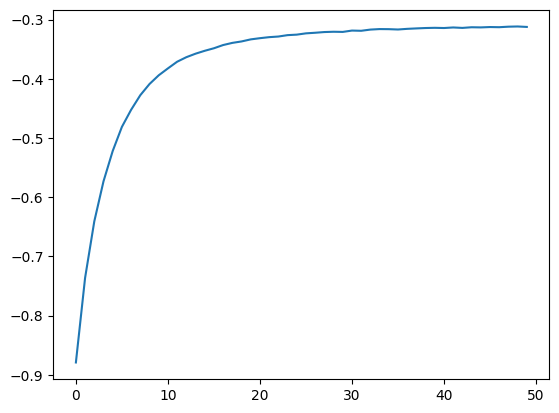

In [9]:
plt.plot(loglikelies)

We can use the testing data to gather metrics on the resulting model.

In [10]:
pred_probs = regressor.predict(X_test)
thresh = 0.5
preds = [int(prob > thresh) for prob in pred_probs]
rights = [pred == ans for pred, ans in zip(preds, y_test)]

In [11]:
print(f"Testing accuracy: {sum(rights) / len(rights)}")

Testing accuracy: 0.8333333333333334


# 